<a href="https://colab.research.google.com/github/shams-mehdi/openmm_langevin/blob/main/Openmm_Langevin_dynamics_metadynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tutorial: Langevin Dynamics (+Metadynamics) with arbitrary potential energy** **functions in OpenMM**

Prerequisites: Change colab runtime to GPU Hardware accelerator


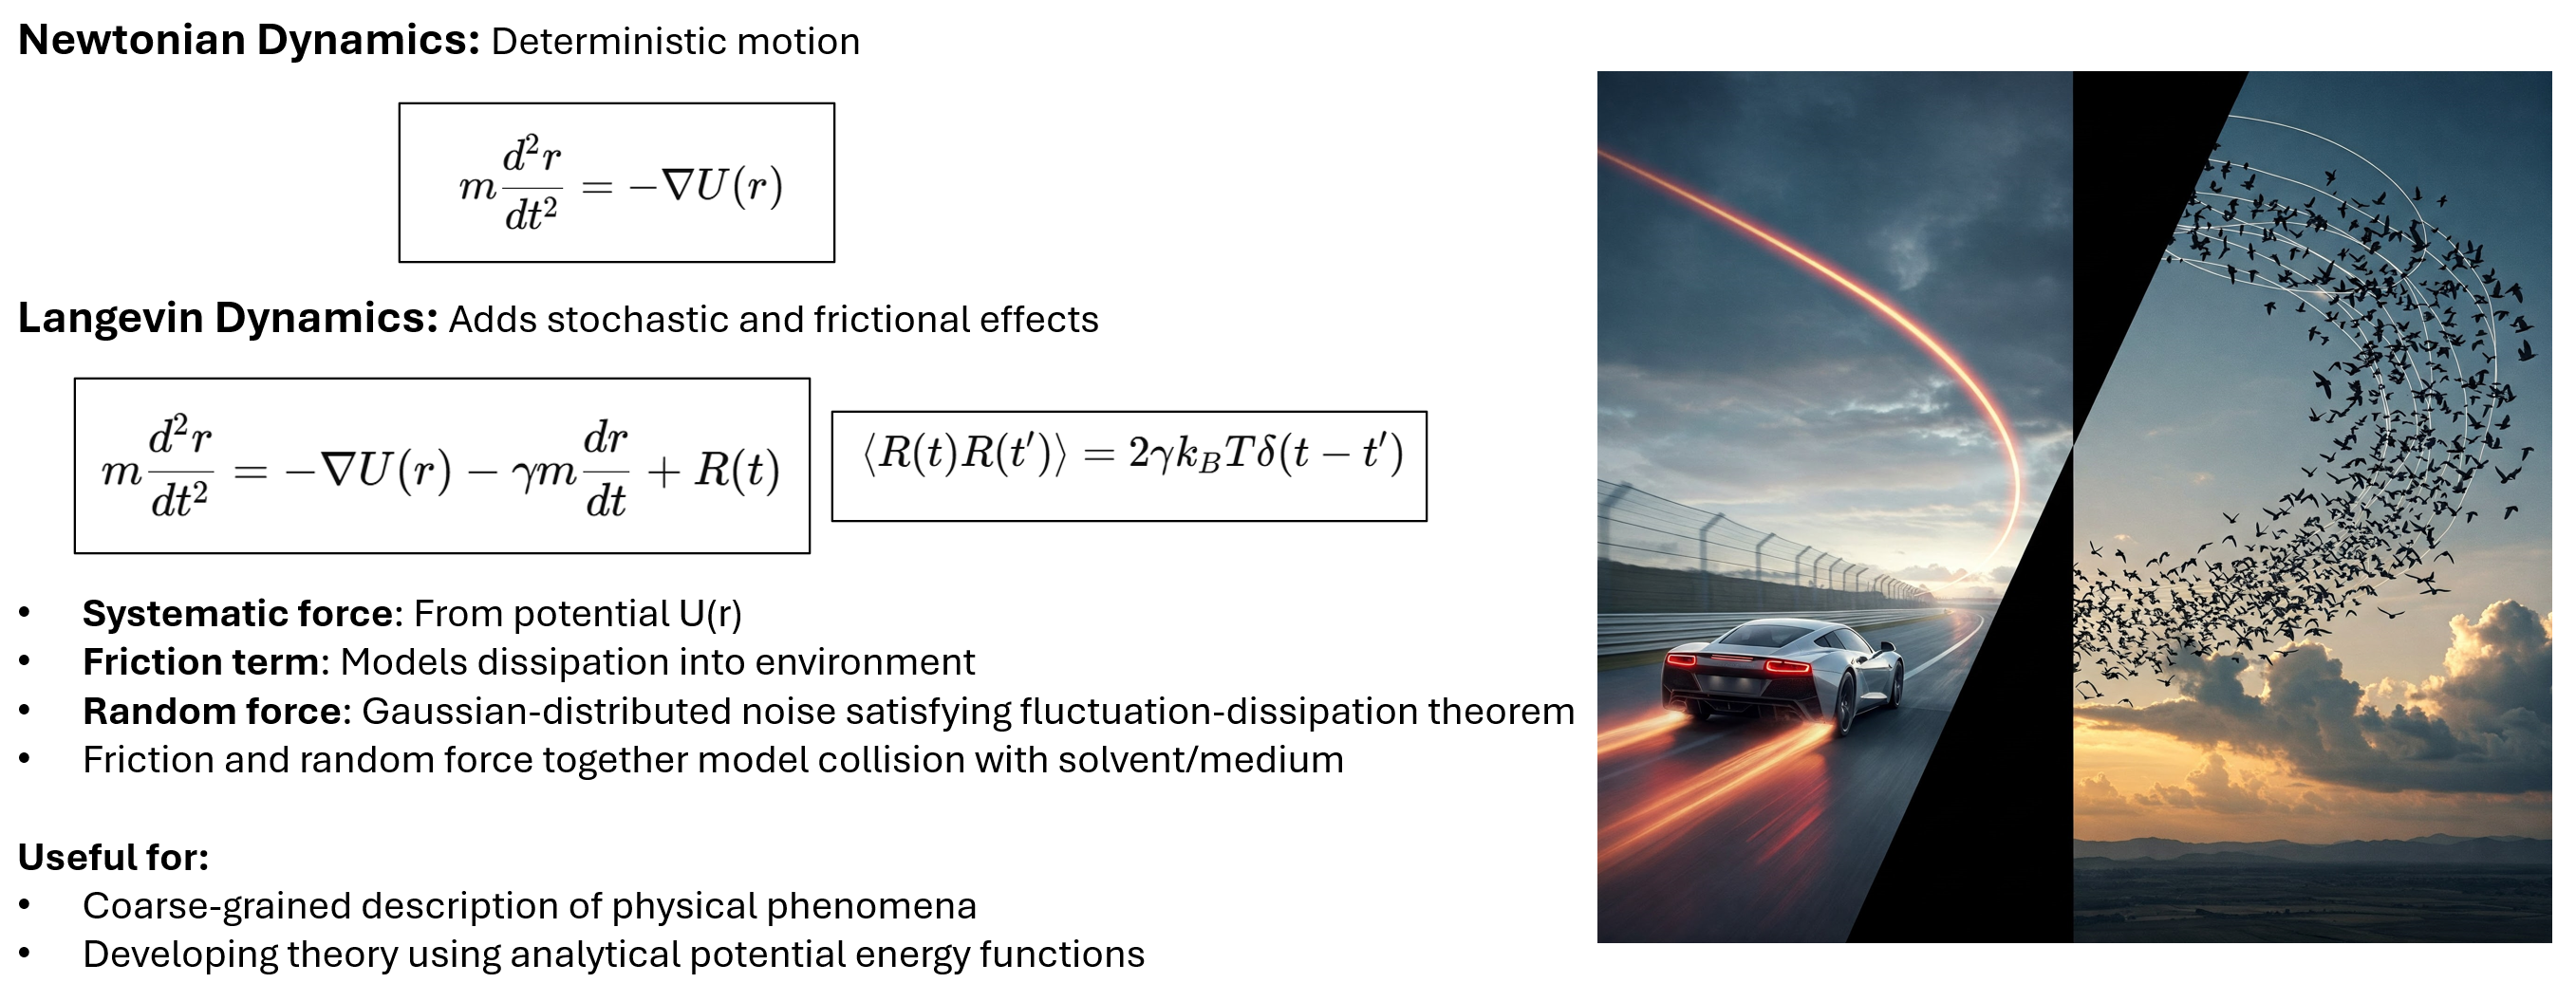

In [1]:
# @title Step 0.a: Install condacolab
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [6]:
# @title Step 0.b: Install packages
!conda install pandas numpy matplotlib openmm plumed openmm-plumed=1.0 -c conda-forge -y
!npx degit shams-mehdi/openmm_langevin -f -y

/bin/bash: line 1: 2.0: No such file or directory
⠙⠹⠸⠼> destination directory is not empty. Using --force, continuing
> cloned shams-mehdi/openmm_langevin#HEAD
⠙

In [25]:
# @title Step 0.c: Load python libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import openmmplumed
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [40]:
# @title Step 1: Set simulation parameters
Temperature_kelvin = 200 # @param {"type":"number"}
Friction_coefficient_per_ps = 1.0 # @param {"type":"number"}
Simulation_steps = 1000000 # @param {"type":"integer"}
Integration_timestep = 0.02 # @param {"type":"number"}
Mass_dalton = 1.0 # @param {"type":"number"}

Metadynamics = True # @param {"type":"boolean"}

temperature = Temperature_kelvin * unit.kelvin
friction = Friction_coefficient_per_ps / unit.picosecond
dt = Integration_timestep * unit.picoseconds
mass = Mass_dalton * unit.dalton

data_save_dir = './data/'
device = 'CUDA'

if Metadynamics == True:
    script_name =  './plumed_scripts/metad.dat'
elif Metadynamics == False:
    script_name = './plumed_scripts/unbiased.dat'
with open(script_name) as f:
    script = f.read()

In [41]:
# @title Step 2: Define potential energy
Two_well = False # @param {"type":"boolean"}
Four_well = False # @param {"type":"boolean"}
Muller_brown = True # @param {"type":"boolean"}

if Two_well == True:
    force = mm.CustomExternalForce("(x^2 - 1)^2 + y^2")

elif Four_well == True:
    force = mm.CustomExternalForce("2*(x^8 + 0.6*e^(-80*x^2) + 0.2*e^(-80*(x-0.5)^2) + 0.5*e^(-40*(x+0.5)^2)) + (x^2-1)^2 + y^2")
    e = np.e
    force.addGlobalParameter("e", e)

elif Muller_brown == True:
    force = mm.CustomExternalForce("A1 * exp(a1 * (x - x1)^2 + b1 * (x - x1) * (y - y1) + c1 * (y - y1)^2) + A2 * exp(a2 * (x - x2)^2 + b2 * (x - x2) * (y - y2) + c2 * (y - y2)^2) + A3 * exp(a3 * (x - x3)^2 + b3 * (x - x3) * (y - y3) + c3 * (y - y3)^2) + A4 * exp(a4 * (x - x4)^2 + b4 * (x - x4) * (y - y4) + c4 * (y - y4)^2)")
    force.addGlobalParameter("A1", -200)
    force.addGlobalParameter("a1", -1)
    force.addGlobalParameter("b1", 0)
    force.addGlobalParameter("c1", -10)
    force.addGlobalParameter("x1", 1)
    force.addGlobalParameter("y1", 0)

    force.addGlobalParameter("A2", -100)
    force.addGlobalParameter("a2", -1)
    force.addGlobalParameter("b2", 0)
    force.addGlobalParameter("c2", -10)
    force.addGlobalParameter("x2", 0)
    force.addGlobalParameter("y2", 0.5)

    force.addGlobalParameter("A3", -170)
    force.addGlobalParameter("a3", -6.5)
    force.addGlobalParameter("b3", 11)
    force.addGlobalParameter("c3", -6.5)
    force.addGlobalParameter("x3", -0.5)
    force.addGlobalParameter("y3", 1.5)

    force.addGlobalParameter("A4", 15)
    force.addGlobalParameter("a4", 0.7)
    force.addGlobalParameter("b4", 0.6)
    force.addGlobalParameter("c4", 0.7)
    force.addGlobalParameter("x4", -1)
    force.addGlobalParameter("y4", 1)

In [42]:
# @title Step 3: Run 3D, 1 particle Langevin Dynamics simulation using OpenMM

system = mm.System()
particle_index = system.addParticle(mass)
force.addParticle(particle_index, [])
system.addForce(force)

integrator = mm.LangevinIntegrator(temperature, friction, dt)
platform = mm.Platform.getPlatformByName(device)
simulation = app.Simulation(app.Topology(), system, integrator, platform)
initial_positions = np.array([[-1.0, 0.0, 0.0]]) * unit.nanometers
simulation.context.setPositions(initial_positions)

# Minimize energy
simulation.minimizeEnergy()

system.addForce(openmmplumed.PlumedForce(script))
simulation.context.reinitialize(preserveState=True)

# Run the simulation
for i in tqdm(range(Simulation_steps)):
  simulation.step(1)

100%|██████████| 1000000/1000000 [08:26<00:00, 1974.12it/s]


<ipython-input-43-8109e82e3ff6>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dat_load = pd.read_csv(data_save_dir + '/' + datafile, delim_whitespace = True, skiprows = 1, header = None).to_numpy()[:-100,:].astype(float)


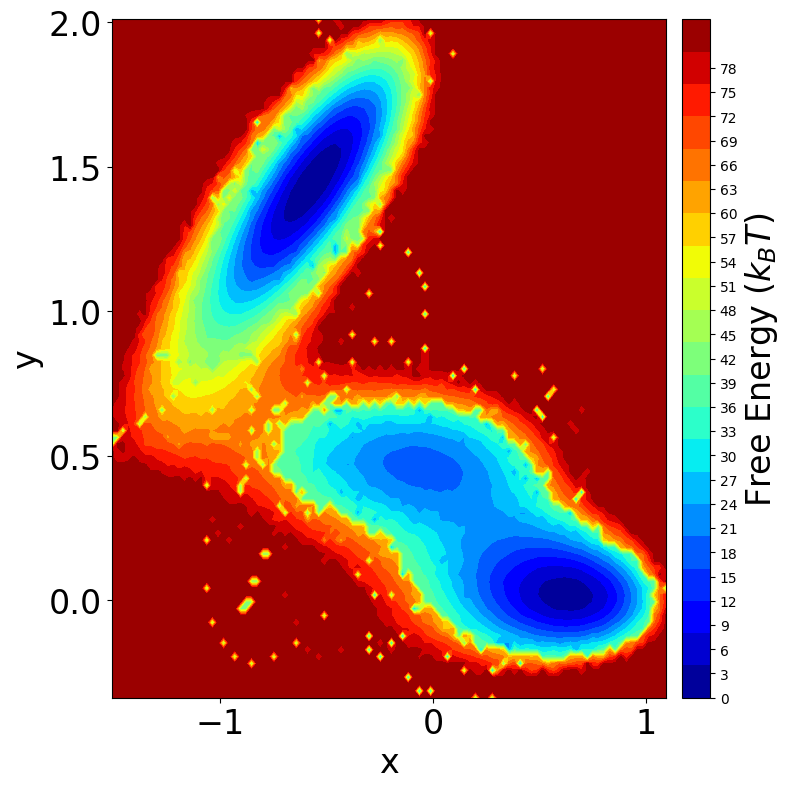

In [43]:
# @title Step 4: Read trajectory and project free energy surface (FES) along X, Y
datafile = "Muller_brown_meta" # @param {"type":"string"}
dat_load = pd.read_csv(data_save_dir + '/' + datafile, delim_whitespace = True, skiprows = 1, header = None).to_numpy()[:-100,:].astype(float)

ff = 24
num_bins = 100
#############################

t = dat_load[:, 0]
x = dat_load[:, 1]
y = dat_load[:, 2]
z = dat_load[:, 3]

if Metadynamics == True:
    k = 1.38E-23
    unit_conversion = 1000/6.023E23
    rbias = dat_load[:, -1]
    weights = np.exp(rbias*unit_conversion/(k*Temperature_kelvin))
else:
  weights = np.ones((t.shape[0]))

fig, ax = plt.subplots(figsize = (8,8))
fig2, ax2 = plt.subplots(figsize = (1,1))

RC_counts,RC_xbins,RC_ybins,images = ax2.hist2d(x, y, bins=num_bins, weights = weights)
plt.close(fig2)

RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=(RC_G-np.nanmin(RC_G))

h0=ax.contourf(RC_G.transpose(),levels=20,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),3)
cb1 = fig.colorbar(h0, cax=cax, orientation="vertical",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)', fontsize = ff)
ax.set_xlabel("x", fontsize = ff)
ax.set_ylabel("y", fontsize = ff)

ax.tick_params(axis='both', which='major', labelsize=ff)
ax.tick_params(axis='both', which='minor', labelsize=8)
fig.tight_layout()